In [50]:
import pathlib 
import wave

import numpy as np
from matplotlib import pyplot as plt



params: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=5278076, comptype='NONE', compname='not compressed')
nframes: 5278076
nchannels: 1
sampwidth: 2
framerate: 16000
(5278058,)
[0 0 0 0 0 0 0 0 0 0]
data is 329.87975 secs


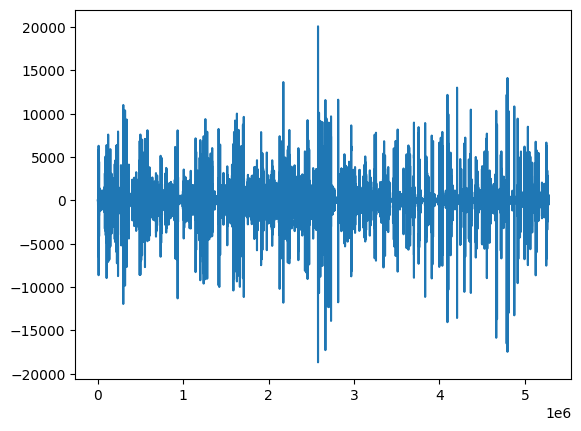

In [12]:
PINGPONG_FILE = pathlib.Path("notebooks/pingpong.wav")

with open(PINGPONG_FILE, "rb") as f, wave.open(f) as wav_file:
    print(f"params: {wav_file.getparams()}")
    print(f"nframes: {wav_file.getnframes()}")
    print(f"nchannels: {wav_file.getnchannels()}")
    print(f"sampwidth: {wav_file.getsampwidth()}")
    print(f"framerate: {wav_file.getframerate()}")

    data = wav_file.readframes(wav_file.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    print(data.shape)
    print(data[:10])
    print(f"data is {wav_file.getnframes() / wav_file.getframerate()} secs")

plt.plot(data)

In [3]:
from IPython.display import Audio

audio_widget = Audio(data[100000:150000], rate=wav_file.getframerate())
display(audio_widget)

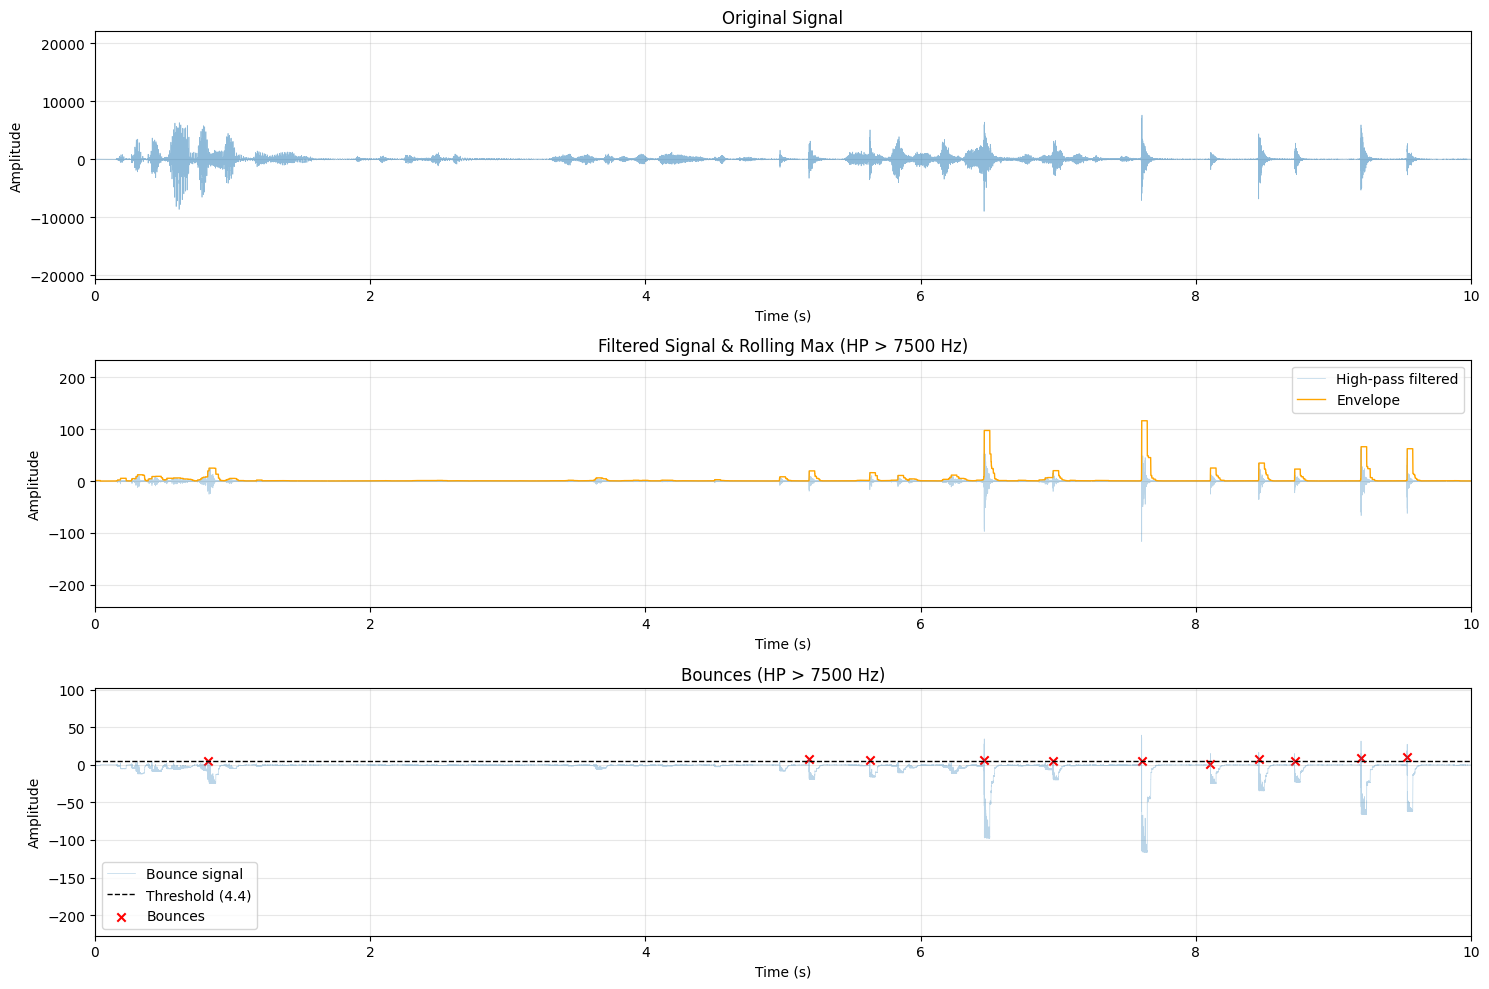

Total bounces detected: 380


In [51]:
from scipy import signal

def count_pingpong_bounces(audio_data, sample_rate=16000, 
                          hp_cutoff=7500,           # High-pass filter cutoff (Hz)
                          window_size_ms=20,        # Window size for rolling max (ms)
                          threshold_factor=0.95,    # Threshold quantile to detect a "bounce"
                          min_bounce_gap=0.08,      # Minimum gap between bounces (seconds)
                          visualization=True):
    
    # 1. High-pass filter to remove voice (typically < 3-4 kHz)
    sos = signal.butter(4, hp_cutoff, btype='highpass', fs=sample_rate, output='sos')
    filtered = signal.sosfilt(sos, audio_data)
    
    conv_window_size=  int(window_size_ms / 1000 * sample_rate) 
    # conv_weights = np.ones(conv_window_size) / conv_window_size  
    # conv_filtered = np.convolve(filtered, conv_weights, mode='valid')

    windows = np.lib.stride_tricks.sliding_window_view(
        np.pad(filtered, pad_width=(conv_window_size,), mode='constant', constant_values=1), 
        conv_window_size)
    rolling_max = np.max(windows, axis=-1)[:filtered.shape[0]]

    # bounce_signal = np.pad(np.abs(filtered)[1:] - np.abs(rolling_max)[:-1], pad_width=(1,), mode='constant', constant_values=0)
    bounce_signal = np.abs(filtered)[1:] - np.abs(rolling_max)[:-1]
    min_bounce_gap_samples = int(min_bounce_gap * sample_rate)

    i = 0
    bounce_threshold = np.quantile(bounce_signal[bounce_signal > 0], 0.95)
    bounces_timestamps = []
    while i < len(bounce_signal):
        if bounce_signal[i] > bounce_threshold:
            bounces_timestamps.append(i / sample_rate)
            i += min_bounce_gap_samples
        else:
            i += 1
    bounces_timestamps = np.array(bounces_timestamps)

    # Visualization
    if visualization:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        xlim = (0, 10)

        # Original signal
        time_axis = np.arange(len(audio_data)) / sample_rate
        axes[0].plot(time_axis, audio_data, alpha=0.5, linewidth=0.5)
        axes[0].set_title('Original Signal')
        axes[0].set_ylabel('Amplitude')
        axes[0].set_xlabel('Time (s)')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_xlim(xlim)
        
        # Filtered signal with envelope
        axes[1].plot(time_axis[:len(filtered)], filtered, alpha=0.3, linewidth=0.5, label='High-pass filtered')
        # axes[1].plot(time_axis[:len(conv_filtered)], conv_filtered, alpha=0.3, linewidth=0.5, label='High-pass conv filtered')
        axes[1].plot(time_axis[:len(rolling_max)], rolling_max, color='orange', linewidth=1, label='Envelope')
        axes[1].set_title(f'Filtered Signal & Rolling Max (HP > {hp_cutoff} Hz)')
        axes[1].set_ylabel('Amplitude')
        axes[1].set_xlabel('Time (s)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xlim(xlim)

        # Bounce detection
        axes[2].plot(time_axis[:len(bounce_signal)], bounce_signal, alpha=0.3, linewidth=0.5, label='Bounce signal')
        axes[2].axhline(bounce_threshold, color='k', linestyle='--', linewidth=1, label=f'Threshold ({bounce_threshold:.1f})')
        plt.scatter(bounces_timestamps, bounce_signal[(bounces_timestamps*sample_rate).astype(int)], color='r', marker='x', label='Bounces')
        axes[2].set_title(f'Bounces (HP > {hp_cutoff} Hz)')
        axes[2].set_ylabel('Amplitude')
        axes[2].set_xlabel('Time (s)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        axes[2].set_xlim(xlim)

        plt.tight_layout()
        plt.show()
    
    return bounces_timestamps

# Test the function
bounces_timestamps = count_pingpong_bounces(data, sample_rate=wav_file.getframerate(), window_size_ms=40)
print(f"Total bounces detected: {len(bounces_timestamps)}")


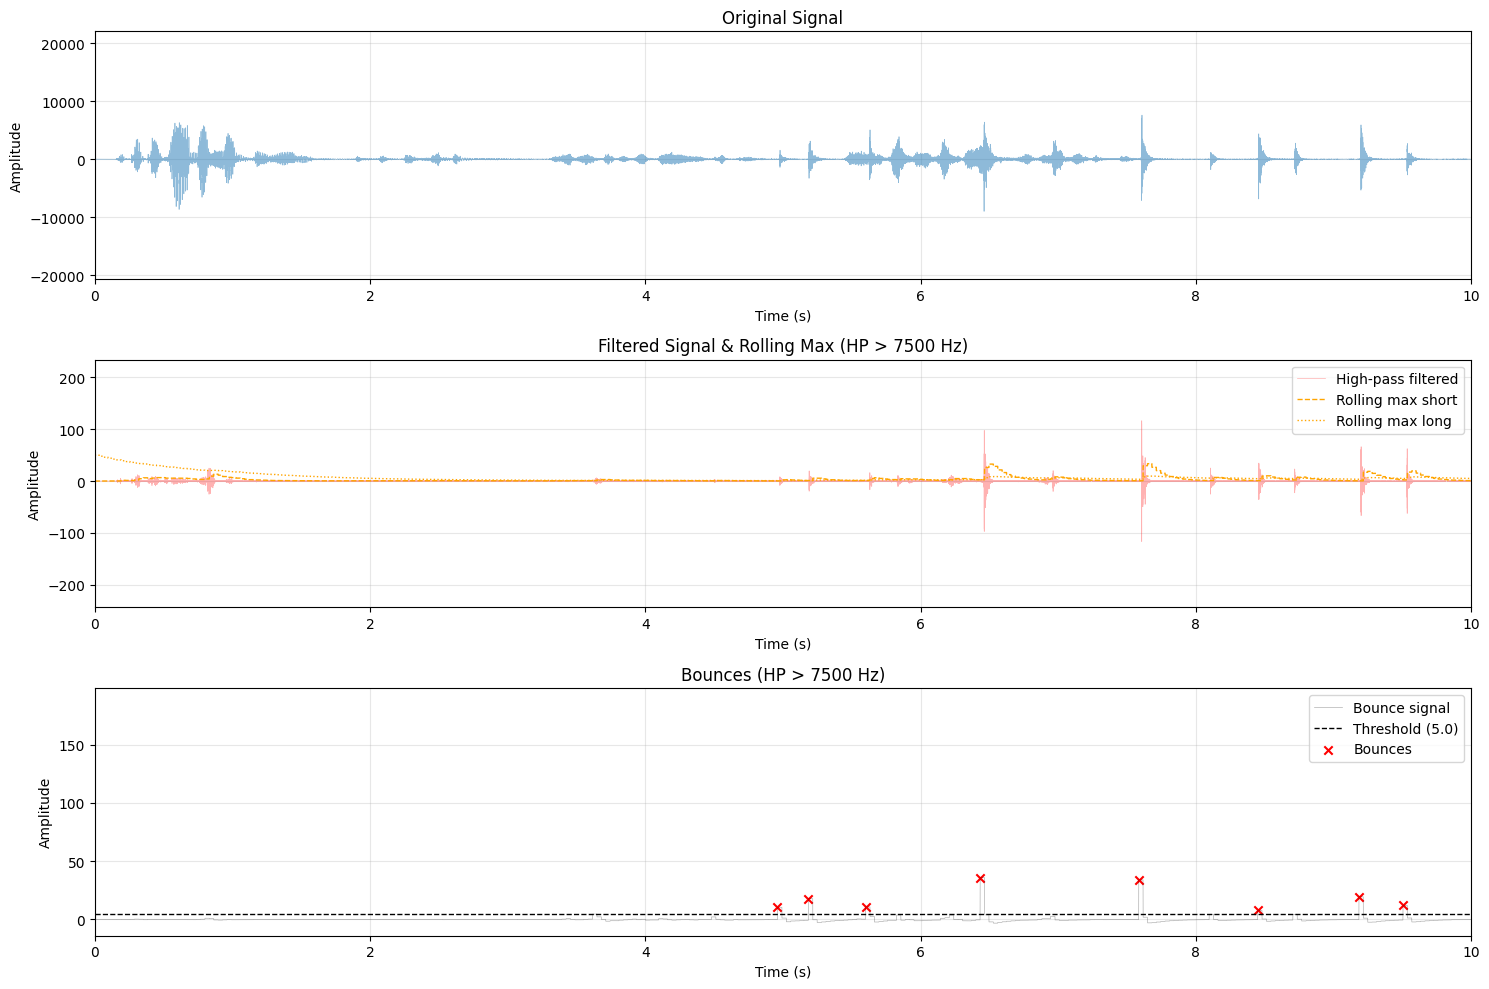

Total bounces detected: 350


In [99]:
from scipy import signal

def count_pingpong_bounces(audio_data, sample_rate=16000, 
                          hp_cutoff=7500,           # High-pass filter cutoff (Hz)
                          window_size_ms=20,        # Window size for rolling max (ms)
                          threshold_factor=0.95,    # Threshold quantile to detect a "bounce"
                          min_bounce_gap=0.08,      # Minimum gap between bounces (seconds)
                          visualization=True):
    
    # 1. High-pass filter to remove voice (typically < 3-4 kHz)
    sos = signal.butter(4, hp_cutoff, btype='highpass', fs=sample_rate, output='sos')
    filtered = signal.sosfilt(sos, audio_data)
    
    moving_window_max = []
    for i in range(0, len(data), 512):
        value = np.max(np.abs(filtered[i:i+512]))
        moving_window_max.extend([value]*512)
    moving_window_max = np.array(moving_window_max)[:filtered.shape[0]]

    rolling_max_short = [0] * 512
    alpha = 0.750
    for i in range(1, len(data), 512):
        value = alpha * rolling_max_short[i - 1] + (1 - alpha) * moving_window_max[i]
        rolling_max_short.extend([value]*512)
    rolling_max_short = np.array(rolling_max_short)[:filtered.shape[0]]


    rolling_max_long = [50] * 512
    alpha = 0.959
    for i in range(1, len(data), 512):
        value = alpha * rolling_max_long[i - 1] + (1 - alpha) * moving_window_max[i]
        rolling_max_long.extend([value]*512)
    rolling_max_long = np.array(rolling_max_long)[:filtered.shape[0]]

    bounce_signal = []
    bounce_threshold = 5
    for i in range(0, len(data), 512):
        value = np.max(np.abs(filtered[i:i+512])) - rolling_max_short[i]
        bounce_signal.extend([value]*512)
    bounce_signal = np.array(bounce_signal)[:filtered.shape[0]]
    bounce_signal = bounce_signal / rolling_max_long[:bounce_signal.shape[0]]
    bounces_indices = (np.argwhere(bounce_signal[::512] > bounce_threshold) * 512).flatten()
    bounces_timestamps = bounces_indices / sample_rate


    # Visualization
    if visualization:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        xlim = (0, 10)

        # Original signal
        time_axis = np.arange(len(audio_data)) / sample_rate
        axes[0].plot(time_axis, audio_data, alpha=0.5, linewidth=0.5)
        axes[0].set_title('Original Signal')
        axes[0].set_ylabel('Amplitude')
        axes[0].set_xlabel('Time (s)')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_xlim(xlim)
        
        # Filtered signal with envelope
        axes[1].plot(time_axis[:len(filtered)], filtered, c="r", alpha=0.3, linewidth=0.5, label='High-pass filtered')
        axes[1].plot(time_axis[:len(rolling_max_short)], rolling_max_short, color='orange', linewidth=1, linestyle="--", label='Rolling max short')
        axes[1].plot(time_axis[:len(rolling_max_long)], rolling_max_long, color='orange', linestyle=":", linewidth=1, label='Rolling max long')
        axes[1].set_title(f'Filtered Signal & Rolling Max (HP > {hp_cutoff} Hz)')
        axes[1].set_ylabel('Amplitude')
        axes[1].set_xlabel('Time (s)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xlim(xlim)

        # Bounce detection
        axes[2].plot(time_axis[:len(bounce_signal)], bounce_signal, c="k", alpha=0.3, linewidth=0.5, label='Bounce signal')
        axes[2].axhline(bounce_threshold, color='k', linestyle='--', linewidth=1, label=f'Threshold ({bounce_threshold:.1f})')
        plt.scatter(bounces_timestamps, bounce_signal[(bounces_timestamps*sample_rate).astype(int)], color='r', marker='x', label='Bounces')
        axes[2].set_title(f'Bounces (HP > {hp_cutoff} Hz)')
        axes[2].set_ylabel('Amplitude')
        axes[2].set_xlabel('Time (s)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        axes[2].set_xlim(xlim)

        plt.tight_layout()
        plt.show()
    
    return bounces_timestamps

# Test the function
bounces_timestamps = count_pingpong_bounces(data, sample_rate=wav_file.getframerate(), window_size_ms=40)
print(f"Total bounces detected: {len(bounces_timestamps)}")


# Create a video file

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from moviepy import VideoClip, AudioFileClip
from scipy.io import wavfile
import tempfile
import os

def create_bounce_detection_video(data, bounce_timestamps, sample_rate=16000,
                                   duration_seconds=None, start_time=0,
                                   output_file='bounce_detection.mp4'):
    """
    Create a video with audio and visual bounce indicators.
    
    Parameters:
    -----------
    data : array
        Audio samples
    bounce_timestamps : array
        Array of bounce timestamps in seconds
    sample_rate : int
        Sample rate (default 16000 Hz)
    duration_seconds : float, optional
        Duration to include (default: all data)
    start_time : float
        Start time in seconds (default: 0)
    output_file : str
        Output video filename
    """
    
    # Calculate start and end samples
    start_sample = int(start_time * sample_rate)
    if duration_seconds is None:
        end_sample = len(data)
        duration_seconds = len(data) / sample_rate
    else:
        end_sample = min(start_sample + int(duration_seconds * sample_rate), len(data))
        duration_seconds = (end_sample - start_sample) / sample_rate
    
    # Get data segment
    data_segment = data[start_sample:end_sample]
    time_axis = np.arange(len(data_segment)) / sample_rate + start_time
    
    # Filter bounces to only those in the time window
    bounce_mask = (bounce_timestamps >= start_time) & (bounce_timestamps < start_time + duration_seconds)
    bounces_in_window = bounce_timestamps[bounce_mask]
    
    print(f"Creating video: {duration_seconds:.2f} seconds")
    print(f"Bounces in window: {len(bounces_in_window)}")
    print(f"Output: {output_file}")
    
    # Save audio to temporary WAV file
    temp_wav = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
    # Normalize audio to int16 range if needed
    audio_normalized = np.int16(data_segment / np.max(np.abs(data_segment)) * 32767)
    wavfile.write(temp_wav.name, sample_rate, audio_normalized)
    temp_wav.close()
    
    # Load audio with moviepy
    audio_clip = AudioFileClip(temp_wav.name)
    
    fps = 30  # Video frames per second
    bounce_flash_duration = 0.4  # seconds
    
    def make_frame(t):
        """Generate a single frame at time t (in seconds)"""
        current_time = start_time + t
        
        # Create figure
        fig, ax = plt.subplots(figsize=(16, 9), facecolor='black')
        ax.set_facecolor('black')
        
        # Plot waveform
        ax.plot(time_axis, data_segment, alpha=0.6, linewidth=0.5, color='cyan')
        ax.set_xlabel('Time (s)', fontsize=14, color='white')
        ax.set_ylabel('Amplitude', fontsize=14, color='white')
        ax.set_title('🏓 Ping Pong Bounce Detection', fontsize=18, fontweight='bold', color='white')
        ax.grid(True, alpha=0.2, color='gray')
        ax.set_xlim(start_time, start_time + duration_seconds)
        ax.tick_params(colors='white')
        
        # Add bounce markers (static red lines)
        for bounce_time in bounces_in_window:
            ax.axvline(bounce_time, color='red', alpha=0.3, linewidth=1, linestyle='--')
        
        # Check if we're at a bounce RIGHT NOW
        flash_alpha = 0
        near_bounce = False
        for bounce_time in bounces_in_window:
            time_diff = current_time - bounce_time
            if 0 <= time_diff <= bounce_flash_duration:
                # Calculate flash intensity (fade out)
                flash_alpha = max(flash_alpha, 1 - (time_diff / bounce_flash_duration))
                near_bounce = True
                # Highlight the current bounce
                ax.axvline(bounce_time, color='red', alpha=1.0, linewidth=4, linestyle='-')
        
        # Draw playhead (green line showing current position)
        ax.axvline(current_time, color='lime', linewidth=3, label='▶ Now', zorder=10, alpha=0.9)
        
        # Flash the background when bounce detected
        if near_bounce:
            # Full screen flash effect
            y_min, y_max = ax.get_ylim()
            ax.add_patch(Rectangle((start_time, y_min), 
                                  duration_seconds, y_max - y_min,
                                  color='red', alpha=flash_alpha * 0.3, zorder=1))
            
            # Large bounce indicator at top
            ax.text(0.5, 0.95, '🏓 BOUNCE DETECTED! 🏓', transform=ax.transAxes,
                   fontsize=36, fontweight='bold', color='white',
                   ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='red', 
                            edgecolor='yellow', linewidth=3,
                            alpha=flash_alpha, pad=0.8))
        
        # Progress indicator
        progress = (current_time - start_time) / duration_seconds * 100
        ax.text(0.02, 0.98, f'⏱️  {current_time:.2f}s / {start_time + duration_seconds:.1f}s  ({progress:.0f}%)', 
               transform=ax.transAxes, fontsize=13, color='white',
               va='top',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7, pad=0.5))
        
        # Bounce counter
        bounces_so_far = np.sum(bounces_in_window <= current_time)
        ax.text(0.98, 0.98, f'🏓 Bounces: {bounces_so_far}/{len(bounces_in_window)}', 
               transform=ax.transAxes, fontsize=13, color='white',
               ha='right', va='top',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7, pad=0.5))
        
        ax.legend(loc='upper right', fontsize=11, facecolor='black', 
                 edgecolor='white', labelcolor='white')
        
        plt.tight_layout()
        
        # Convert figure to numpy array (RGB) - FIXED for newer matplotlib
        fig.canvas.draw()
        # Use buffer_rgba() instead of tostring_rgb()
        buf = fig.canvas.buffer_rgba()
        frame = np.asarray(buf)
        # Convert RGBA to RGB
        frame = frame[:, :, :3]
        
        plt.close(fig)
        return frame
    
    # Create video clip
    print("\n🎬 Generating video... This may take a minute...")
    video_clip = VideoClip(make_frame, duration=duration_seconds)
    video_clip = video_clip.with_fps(fps)
    
    # Combine video and audio
    final_clip = video_clip.with_audio(audio_clip)
    
    # Write to file
    final_clip.write_videofile(output_file, 
                               codec='libx264',
                               audio_codec='aac',
                               fps=fps,
                               preset='medium',
                               bitrate='2000k')
    
    # Cleanup
    video_clip.close()
    audio_clip.close()
    os.unlink(temp_wav.name)
    
    print(f"\n✅ Video created successfully: {output_file}")
    print(f"   You can now play it in any video player!")
    
    return output_file

# Example usage:
video_file = create_bounce_detection_video(
    data, 
    bounces_timestamps, 
    sample_rate=16000,
    duration_seconds=30,  # 20 seconds
    start_time=0,        # Start at 10 seconds
    output_file='bounce_detection_demo.mp4'
)

Creating video: 30.00 seconds
Bounces in window: 35
Output: bounce_detection_demo.mp4

🎬 Generating video... This may take a minute...
MoviePy - Building video bounce_detection_demo.mp4.
MoviePy - Writing audio in bounce_detection_demoTEMP_MPY_wvf_snd.mp4


/var/folders/wv/5s81fs494v17dzbqfghxlf8c0000gp/T/ipykernel_46476/1348565632.py:134: UserWarning: Glyph 127955 (\N{TABLE TENNIS PADDLE AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wv/5s81fs494v17dzbqfghxlf8c0000gp/T/ipykernel_46476/1348565632.py:134: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wv/5s81fs494v17dzbqfghxlf8c0000gp/T/ipykernel_46476/1348565632.py:137: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/var/folders/wv/5s81fs494v17dzbqfghxlf8c0000gp/T/ipykernel_46476/1348565632.py:137: UserWarning: Glyph 127955 (\N{TABLE TENNIS PADDLE AND BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
chunk:  84%|████████▍ | 559/662 [00:00<00:00, 1781.54it/s, now=None]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python 

MoviePy - Done.
MoviePy - Writing video bounce_detection_demo.mp4



MoviePy - Done !
MoviePy - video ready bounce_detection_demo.mp4

✅ Video created successfully: bounce_detection_demo.mp4
   You can now play it in any video player!


: 

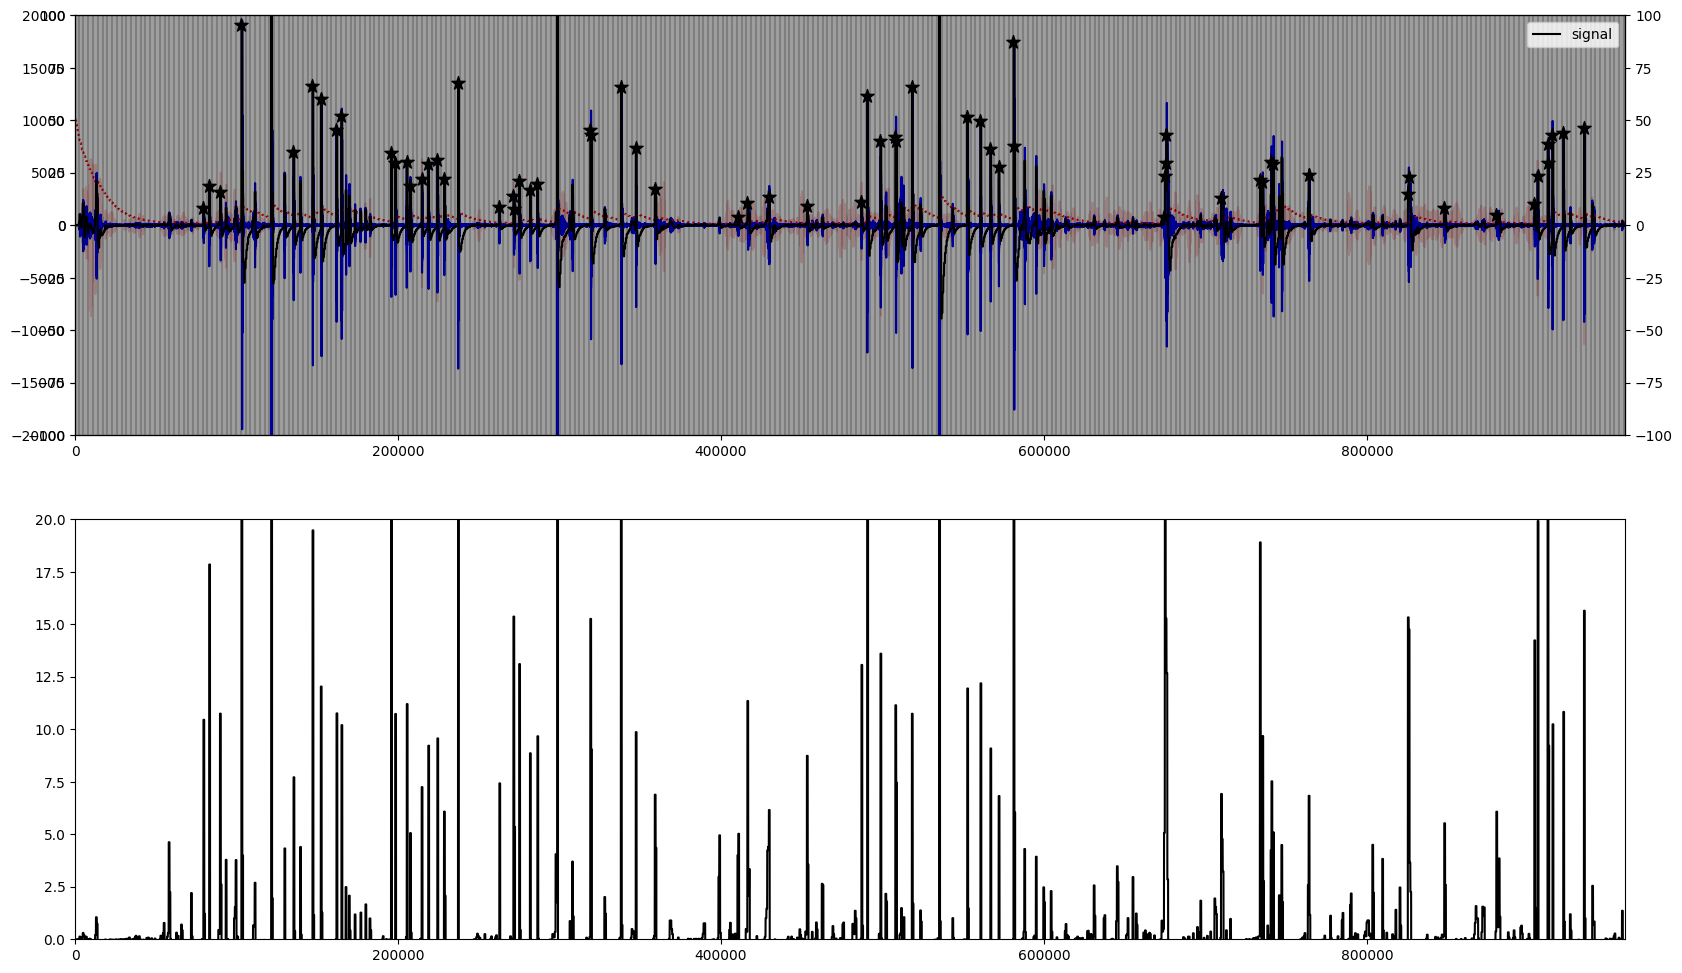

In [ ]:
f = 0
t = 16000*60 #2**17
slc = np.arange(f, t)

sos = signal.butter(4, 7500, btype='highpass', fs=wav_file.getframerate(), output='sos')
filtered = signal.sosfilt(sos, data)

moving_window_max = []
for i in range(0, len(data), 512):
    value = np.max(np.abs(filtered[i:i+512]))
    moving_window_max.extend([value]*512)
moving_window_max = np.array(moving_window_max)

rolling_max_short = [0] * 512
alpha = 0.750
for i in range(1, len(data), 512):
    value = alpha * rolling_max_short[i - 1] + (1 - alpha) * moving_window_max[i]
    rolling_max_short.extend([value]*512)
rolling_max_short = np.array(rolling_max_short)


rolling_max_long = [50] * 512
alpha = 0.959
for i in range(1, len(data), 512):
    value = alpha * rolling_max_long[i - 1] + (1 - alpha) * moving_window_max[i]
    rolling_max_long.extend([value]*512)
rolling_max_long = np.array(rolling_max_long)


s = []
for i in range(0, len(data), 512):
    value = np.max(np.abs(filtered[i:i+512])) - rolling_max_short[i]
    s.extend([value]*512)
s = np.array(s)


fig, axes = plt.subplots(2, 1, figsize=(20,12))


ax = axes[0]
ax.plot(slc, data[f:t], c="r", alpha=0.2, label="original")
ax.set_ylim(-20000, 20000)
ax.set_xlim(f, t)

ax = ax.twinx()
ax.plot(slc, filtered[f:t], c="b", alpha=1, label="filtered")
# ax.plot(slc, moving_window_max[f:t], c="g", alpha=1, label="moving window max")
# ax.plot(slc, rolling_max_short[f:t], c="r", linestyle="--", alpha=1, label="rolling max short")
ax.plot(slc, rolling_max_long[f:t], c="r", linestyle=":", alpha=1, label="rolling max long")
ax.set_ylim(-100, 100)
ax.set_xlim(f, t)

ax = ax.twinx()
ax.plot(slc, s[f:t], c="k", alpha=1, label="signal")
ax.set_ylim(-100, 100)
ax.set_xlim(f, t)


boundaries = np.arange(0, len(data), 512)
for x in boundaries[(f <= boundaries) & (boundaries <= t)]:
    ax.axvline(x, c="k", alpha=0.2)


_s = s / rolling_max_long[:s.shape[0]]
_indices = (np.argwhere(_s[::512] > 5) * 512).flatten()
ax.scatter(_indices, s[_indices], c="k", marker="*", s=100,  alpha=1)




ax = axes[1]
ax.plot(s / rolling_max_long[:s.shape[0]], c="k")
ax.set_xlim(f, t)
ax.set_ylim(0, 20)


plt.legend()
plt.show()

    


array([[  79360],
       [  82944],
       [  89600],
       [ 102912],
       [ 121344],
       [ 135168],
       [ 146944],
       [ 152064],
       [ 161792],
       [ 164864],
       [ 195584],
       [ 198144],
       [ 205312],
       [ 207360],
       [ 214528],
       [ 218624],
       [ 224256],
       [ 228352],
       [ 237056],
       [ 262656],
       [ 271360],
       [ 271872],
       [ 274944],
       [ 281600],
       [ 286208],
       [ 298496],
       [ 318976],
       [ 319488],
       [ 337920],
       [ 347136],
       [ 358912],
       [ 410624],
       [ 416256],
       [ 429568],
       [ 453120],
       [ 486912],
       [ 490496],
       [ 498688],
       [ 507904],
       [ 508416],
       [ 518144],
       [ 535040],
       [ 552448],
       [ 560640],
       [ 566784],
       [ 571904],
       [ 581120],
       [ 581632],
       [ 674304],
       [ 674816],
       [ 675328],
       [ 675840],
       [ 709632],
       [ 733696],
       [ 735232],
       [ 7